In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

results_tables = {
    'planner_2000': '../experiments_sim/results/experiments_planner_2000_results.csv',
    'planner_200': '../experiments_sim/results/experiments_planner_200_results.csv',
    'handmade': '../experiments_sim/results/experiments_handmade_results.csv',
}

dataframes = {
    key: pd.read_csv(value) for key, value in results_tables.items()
}

FileNotFoundError: [Errno 2] No such file or directory: '../../experiments_sim/results/experiments_planner_2000_results.csv'

In [ ]:

dataframes['planner_2000'].head(10)

first for general understanding, print the mean accumulated reward with help, without help, and total for each planner

In [4]:
# in each df there is just accumulated rewards column
for key, df in dataframes.items():
    print("--------")
    print(key)
    print("--------")
    print(f"mean accumulated reward {df['accumulated_rewards'].mean()}")
    print(f"mean accumulated reward without help {df[df['help_config_idx_local'] == -1]['accumulated_rewards'].mean()}")
    print(f"mean accumulated reward with help {df[df['help_config_idx_local'] != -1]['accumulated_rewards'].mean()}")
    print("num of beliefs: ", len(df['belief_idx'].unique()))
    print("num of states: ", len(df['state_idx'].unique()))
    print("num of help configs: ", len(df['help_config_idx_local'].unique()) - 1 )

    mean_pickup_attempts_no_help = df[df['help_config_idx_local'] == -1]['n_pickup_attempts'].mean()
    mean_successful_pickup_no_help = df[df['help_config_idx_local'] == -1]['n_successful_pickups'].mean()
    ratio_no_help = mean_successful_pickup_no_help / mean_pickup_attempts_no_help
    print (f"mean num of pickup attempts without help: {mean_pickup_attempts_no_help},"
           f" succesful pickups: {mean_successful_pickup_no_help},"
           f" successful pickup ratio: {ratio_no_help}")

--------
planner_2000
--------
mean accumulated reward 2.2912040922727233
mean accumulated reward without help 0.555080423159274
mean accumulated reward with help 2.3346071840005593
num of beliefs:  25
num of states:  10
num of help configs:  40
mean num of pickup attempts without help: 2.068, succesful pickups: 0.708, successful pickup ratio: 0.34235976789168276
--------
planner_200
--------
mean accumulated reward 2.28033530720073
mean accumulated reward without help 0.7192336933747016
mean accumulated reward with help 2.319362847546381
num of beliefs:  25
num of states:  10
num of help configs:  40
mean num of pickup attempts without help: 5.136, succesful pickups: 0.996, successful pickup ratio: 0.1939252336448598
--------
handmade
--------
mean accumulated reward 2.138060746272079
mean accumulated reward without help 1.1537006565088008
mean accumulated reward with help 2.1626697485161612
num of beliefs:  25
num of states:  10
num of help configs:  40
mean num of pickup attempts wi

Create new dataframe for value difference between with help and without help for each help config

In [7]:
from data_processing.process_experiments_results import experiments_results_to_empirical_vd_table
value_diff_dfs = {}
for key, df in dataframes.items():
    vd_df = experiments_results_to_empirical_vd_table(df)
    vd_df = vd_df[['experiment_id', 'belief_idx', 'state_idx', 'help_config_idx_local', 'value_diff']]
    value_diff_dfs[key] = vd_df


In [8]:
value_diff_dfs['planner_2000'].head(5)

,experiment_id,belief_idx,state_idx,help_config_idx_local,value_diff
0,2,0,0,0,0.866670
1,3,0,0,1,0.948819
2,4,0,0,2,1.915507
3,5,0,0,3,-0.140075
4,6,0,0,4,3.181784


Try using help as empirical mean estimator to VOA, then try belief as empirical mean estimator to VOA, then try both

In [9]:
def empirical_mean_estimator_belief(df, belief_idx):
    belief_df = df[df['belief_idx'] == belief_idx]
    return belief_df['value_diff'].mean()

def empirical_mean_estimator_help(df, help_config_idx):
    help_df = df[df['help_config_idx_local'] == help_config_idx]
    return help_df['value_diff'].mean()

def empirical_mean_estimator_both(df, belief_idx, help_config_idx):
    both_df = df[(df['belief_idx'] == belief_idx) & (df['help_config_idx_local'] == help_config_idx)]
    return both_df['value_diff'].mean()

In [10]:
def test_estimators_results(value_diff_df):
    # use estimator on all samples and compute mean error
    belief_errors = []
    help_errors = []
    both_errors = []
    for belief_idx in value_diff_df['belief_idx'].unique():
        belief_error = np.abs(value_diff_df[value_diff_df['belief_idx'] == belief_idx]['value_diff'] - empirical_mean_estimator_belief(value_diff_df, belief_idx)).mean()
        belief_errors.append(belief_error)

    for help_config_idx in value_diff_df['help_config_idx_local'].unique():
        help_error = np.abs(value_diff_df[value_diff_df['help_config_idx_local'] == help_config_idx]['value_diff'] - empirical_mean_estimator_help(value_diff_df, help_config_idx)).mean()
        help_errors.append(help_error)

    for belief_idx in value_diff_df['belief_idx'].unique():
        for help_config_idx in value_diff_df['help_config_idx_local'].unique():
            both_error = np.abs(value_diff_df[(value_diff_df['belief_idx'] == belief_idx) & (value_diff_df['help_config_idx_local'] == help_config_idx)]['value_diff'] - empirical_mean_estimator_both(value_diff_df, belief_idx, help_config_idx)).mean()
            both_errors.append(both_error)
    return np.mean(belief_errors), np.mean(help_errors), np.mean(both_errors)

In [11]:
for key, value_diff_df in value_diff_dfs.items():
    belief_error, help_error, both_error = test_estimators_results(value_diff_df)
    print(f"{key} belief error: {belief_error}")
    print(f"{key} help error: {help_error}")
    print(f"{key} both error: {both_error}")

planner_2000 belief error: 1.0033110199660051
planner_2000 help error: 0.8681344114154361
planner_2000 both error: 0.7834231824069192
planner_200 belief error: 1.113054501661623
planner_200 help error: 0.9874706020677539
planner_200 both error: 0.9047904868998085
handmade belief error: 0.7996411068448167
handmade help error: 0.7794922501419522
handmade both error: 0.7376282006533192


Sample Size Considerations, sample sizes are:
Help action estimates: 250 samples (25 beliefs × 10 states)
Belief estimates: 400 samples (40 help actions × 10 states)
Both combined: 10 samples
Given these sample sizes, it's particularly noteworthy that the "both" estimator performs best despite having the smallest sample size (only 10 samples). This strongly suggests that both belief and help configuration contain important information for prediction, as the improved accuracy outweighs the disadvantage of having fewer samples.

compute std of value diff for each help config- belief pair and plot histogram

In [12]:
def compute_std_for_help_belief_pair(value_diff_df):
    stds = []
    means = []
    for belief_idx in value_diff_df['belief_idx'].unique():
        for help_config_idx in value_diff_df['help_config_idx_local'].unique():
            std = value_diff_df[(value_diff_df['belief_idx'] == belief_idx) & (value_diff_df['help_config_idx_local'] == help_config_idx)]['value_diff'].std()
            mean = value_diff_df[(value_diff_df['belief_idx'] == belief_idx) & (value_diff_df['help_config_idx_local'] == help_config_idx)]['value_diff'].mean()
            stds.append(std)
            means.append(mean)

    # plot histogram of stds and means
    return stds, means

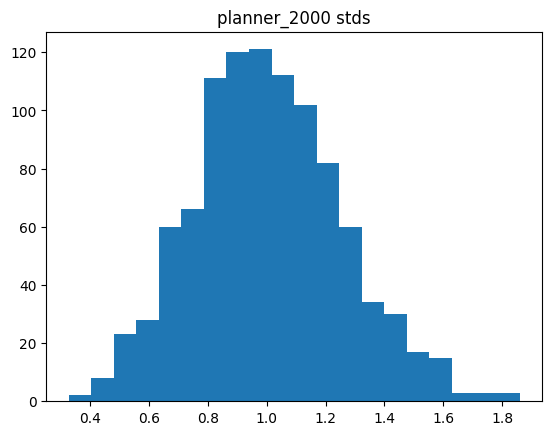

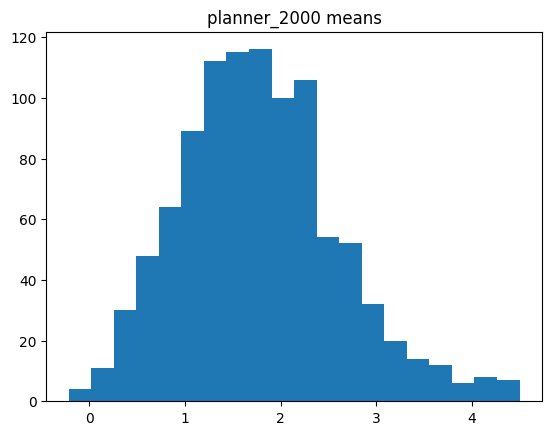

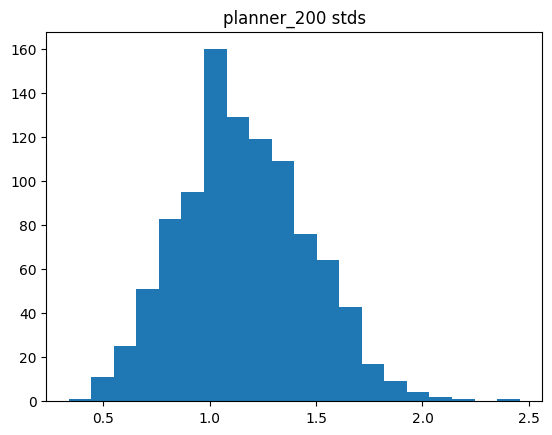

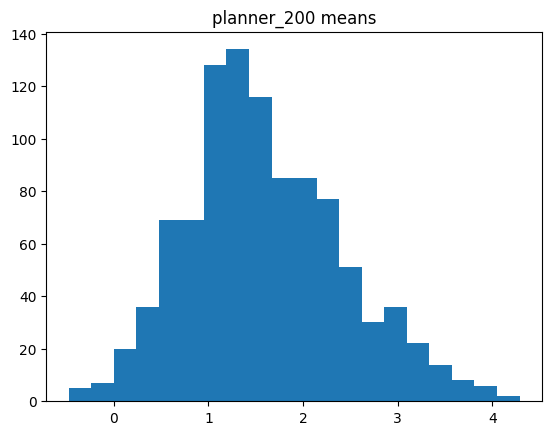

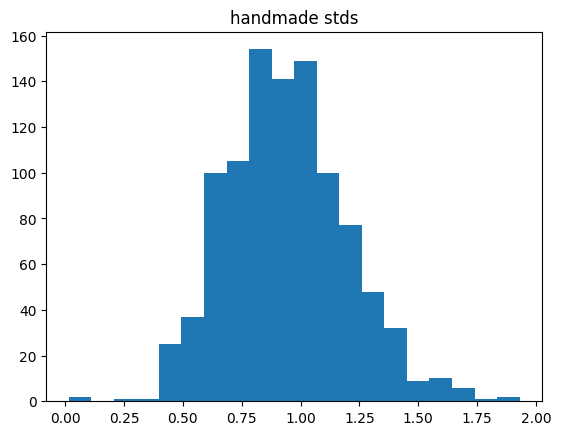

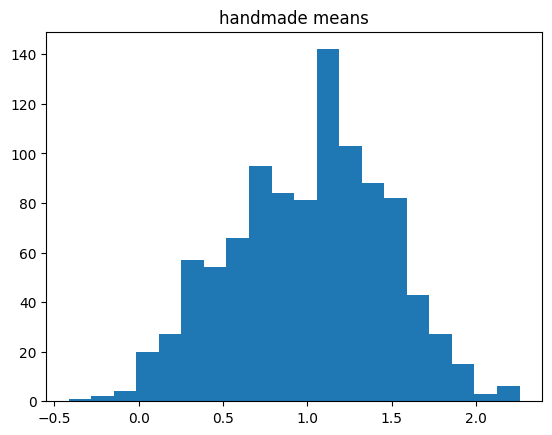

In [13]:
for key, value_diff_df in value_diff_dfs.items():
    stds, means = compute_std_for_help_belief_pair(value_diff_df)
    plt.hist(stds, bins=20)
    plt.title(f"{key} stds")
    plt.show()
    plt.hist(means, bins=20)
    plt.title(f"{key} means")
    plt.show()